In [1]:
import numpy as np
from pprint import pprint
from copy import deepcopy


from laboneq.contrib.example_helpers.generate_descriptor import generate_descriptor
#from laboneq.contrib.example_helpers.generate_device_setup import generate_device_setup
from laboneq.dsl.device import DeviceSetup
from laboneq.simple import *
from laboneq.dsl.device import DeviceSetup
from laboneq.dsl.calibration import Oscillator, SignalCalibration
from laboneq.dsl.enums import ModulationType




# descriptor = generate_descriptor(
#     #pqsc=[""], # 장비 여러개 사용시
#     shfqc_6=["DEV12256"],
#     number_data_qubits=3,
#     multiplex=True,
#     number_multiplex=6,
#     include_cr_lines=False,
#     include_ef_lines=True,
#     get_zsync=False,  # Only set to True when using real device
#     save = True,
#     filename="1port",
#     ip_address="192.168.0.83"
# )


#descriptor
#setup = DeviceSetup.from_descriptor(yaml_text=descriptor, server_host="192.168.0.83")
setup = DeviceSetup.from_yaml(filepath="/Users/yalgaeahn/JSAHN/qubit-experiment/examples/selectiveRIP/Descriptors/1port.yaml" , server_host="192.168.0.83")
#setup
setup.instruments[0].device_options = 'SHFQC/PLUS/QC6CH'
#setup.instruments

In [2]:
bus_ids = [f"b{i}" for i in range(3)]
bus_port = [4,5,6] #used 1,2,3 for qubit drive

for i, bus in zip(bus_port,bus_ids):
    setup.add_connections(
        setup.instruments[0].uid,
        # each bus uses its own drive:
        create_connection(
            to_signal=f"{bus}/drive",
            ports=f"SGCHANNELS/{i}/OUTPUT"
        ))

# Calibrate qubit drive/measure lines for oscillator phase increments
qubit_ids = [uid for uid in setup.logical_signal_groups if uid.startswith("q")]
for qubit in qubit_ids:
    for line, frequency, mod_type in [
        ("drive", 5e9, ModulationType.HARDWARE),
        ("drive_ef", 6e9, ModulationType.HARDWARE),
        ("measure", 4e9, ModulationType.SOFTWARE),
    ]:
        logical_signal = setup.logical_signal_by_uid(f"{qubit}/{line}")
        oscillator = Oscillator(modulation_type=mod_type)
        logical_signal.calibration = SignalCalibration(
            local_oscillator=Oscillator(frequency=frequency),
            oscillator=oscillator,
        )
        if line == "measure":
            acquire_signal = setup.logical_signal_by_uid(f"{qubit}/acquire")
            acquire_signal.calibration = SignalCalibration(
                local_oscillator=Oscillator(frequency=frequency),
                oscillator=oscillator,
            )


In [3]:
from qpu_types.fixed_transmon import FixedTransmonQubit, FixedTransmonQubitParameters
from qpu_types.bus_cavity import BusCavity, BusCavityParameters
from qpu_types.fixed_transmon.operations import FixedTransmonOperations
from qpu_types.bus_cavity.operations import BusCavityOperations
from laboneq.dsl.quantum.qpu import QPU, QuantumPlatform
from helper import load_qubit_parameters, save_qubit_parameters

qubit_uids = [uid for uid in setup.logical_signal_groups if uid.startswith("q")]
bus_uids = [uid for uid in setup.logical_signal_groups if uid.startswith("b")]

qubits = FixedTransmonQubit.from_device_setup(
    setup, qubit_uids=qubit_uids)
buses = BusCavity.from_device_setup(
    setup, qubit_uids=bus_uids)

qpu = QPU(quantum_elements={"qubits" : qubits, "bus" : buses}, quantum_operations=[FixedTransmonOperations, BusCavityOperations])


# from laboneq.simple import workflow
# folder_store = workflow.logbook.FolderStore("./experiment_store") 
# folder_store.activate()
# #folder_store.deactivate()
# #workflow.logbook.LoggingStore().activate()
# #workflow.logbook.LogbookStore().deactivate()


# LOAD QPU

In [4]:
import os
from datetime import datetime
def find_latest_json(folder_path):
    files = [f for f in os.listdir(folder_path)]
    timestamps = []
    for file in files:
        try:
            # Extract a timestamp assuming it's included in the filename
            timestamp_str = file.split('_', 1)[0]  # Assuming YYYYMMDDHHMMSS format
            timestamp = datetime.strptime(timestamp_str, '%Y%m%d-%H%M%S')
            timestamps.append((timestamp, file))
        except ValueError:
            print("fuck")
            continue  # Skip files that do not match the timestamp format

       # Find the most recent file
    if timestamps:
        latest_file = max(timestamps, key=lambda x: x[0])[1]
        return os.path.join(folder_path, latest_file)
    return None

qb_pars_file = find_latest_json("./qpu_parameters/")
print(f"LOADED: {qb_pars_file}")

from qpu_types.fixed_transmon.operations import FixedTransmonOperations
from qpu_types.bus_cavity.operations import BusCavityOperations
import laboneq.dsl.quantum.qpu as qpu_mod

class CombinedOperations(FixedTransmonOperations, BusCavityOperations):
    pass

qpu_mod.CombinedOperations = CombinedOperations

qpu = load(qb_pars_file)

buses = qpu.groups.bus
qubits = qpu.groups.qubits

fuck
LOADED: ./qpu_parameters/20260116-1729_multiplexing_test


# Connection

In [5]:
from laboneq.simple import Session
session = Session(setup)
session.connect(ignore_version_mismatch=False, do_emulation=True)
#session.disconnect()

[2026.02.03 19:33:01.042] INFO    Logging initialized from [Default inline config in laboneq.laboneq_logging] logdir is /Users/yalgaeahn/JSAHN/qubit-experiment/examples/selectiveRIP/laboneq_output/log
[2026.02.03 19:33:01.044] INFO    VERSION: laboneq 25.10.3
[2026.02.03 19:33:01.045] INFO    Connecting to data server at 192.168.0.83:8004
[2026.02.03 19:33:01.047] INFO    Connected to Zurich Instruments LabOne Data Server version 25.10.1.4 at 192.168.0.83:8004
[2026.02.03 19:33:01.050] INFO    Configuring the device setup
[2026.02.03 19:33:01.052] INFO    The device setup is configured


# Ramsey Echo

In [ ]:
from experiments import echo 

q = qubits[1]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
temporary_parameters[q.uid] = temp_pars
#######################################################################
delays = np.linspace(0,20e-6,301)
detunings = 0.5e6,
pprint(q.readout_parameters())
#######################################################################
options = echo.experiment_workflow.options()
options.update(False)
options.count(1024)
options.use_cal_traces(True)
# Build and run Ramsey workflow (no explicit command table options required)
ramsey_wf = echo.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    delays=delays,
    #detunings=detunings,
    options=options,
    temporary_parameters=temporary_parameters
)
ramsey_result = ramsey_wf.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
print(ramsey_result.tasks['analysis_workflow'].output)
ramsey_result.tasks['analysis_workflow'].tasks['plot_population'].output['q1']

# Ramsey

In [ ]:
from laboneq_applications.experiments import ramsey

q = qubits[1]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
#temp_pars.readout_integration_length= 1e-6
temporary_parameters[q.uid] = temp_pars
#######################################################################
delays = np.linspace(0,5e-6,301)
detunings = 2e6 #4e6,
pprint(q.readout_parameters())
#######################################################################
options = ramsey.experiment_workflow.options()
options.update(False)
options.count(512)
options.use_cal_traces(True)
# Build and run Ramsey workflow (no explicit command table options required)
ramsey_wf = ramsey.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    delays=delays,
    detunings=detunings,
    options=options,
    temporary_parameters=temporary_parameters
)
ramsey_result = ramsey_wf.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
print(ramsey_result.tasks['analysis_workflow'].output)
#ramsey_result.tasks['analysis_workflow'].tasks['plot_population'].output['q0']

In [ ]:
qubits[0].parameters.resonance_frequency_ge

# Power calculation

In [ ]:
from helper import adjust_amplitude_for_output_range, calculate_power
#adjust_amplitude_for_output_range(initial_output_dbm=0, initial_amplitude= 0.002, new_output_dbm=-5)
calculate_power(output_dbm=10, amplitude=0.004,attenuation=[])

# Coherence Spectroscopy

ECHO 제거함

In [ ]:
qubits[4].parameters.resonance_frequency_ge = 6.4203e9 #mode3
qubits[2].parameters.resonance_frequency_ge = 5.4947e9 #mode1

qubits[2].parameters.readout_integration_delay = 320e-9

# 0201

- ringup 넣은값 0.9배 일때 ramesy sequence 시작  
- GaussianSquare 실험 코드에서 risefallsigmaratio 수정하기 귀찮아서 spectroscopy 전역으로 0.5 넣어듐
- ring_down 값 넣어서 residual photon decaying 충분히 시킨뒤에 measure하게끔 (아마 불필요 그냥 작은 값 넣으면 될듯)  
- spectroscopy pulse 길이는 opts.ring_up으로 조절

('measure', {'amplitude': 0.5, 'length': 1e-06, 'pulse': {'function': 'GaussianSquare', 'risefall_sigma_ratio': 3.0, 'sigma': 0.2}})
[2026.02.03 19:33:12.337] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.03 19:33:12.338] INFO      Workflow 'coherence_spectroscopy': execution started at 2026-02-03            
[2026.02.03 19:33:12.338] INFO      10:33:12.337462Z                                                              
[2026.02.03 19:33:12.338] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.03 19:33:12.339] INFO    Task 'temporary_qpu': started at 2026-02-03 10:33:12.338979Z
[2026.02.03 19:33:12.339] INFO    Task 'temporary_qpu': ended at 2026-02-03 10:33:12.339735Z
[2026.02.03 19:33:12.340] INFO    Task 'temporary_quantum_elements_from_qpu': started at 2026-02-03 
[2026.02.03 19:33:12.340] INFO    10:33:12.340114Z
[2026.02.03 19:33:12.340] INFO    Task 'temporary_quantum_elements_

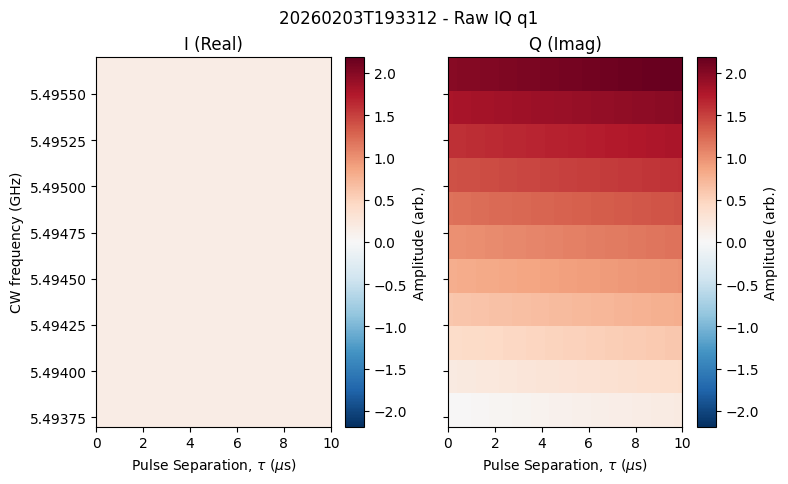

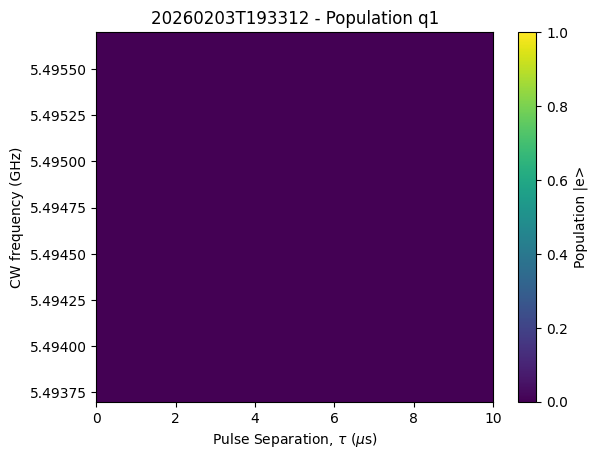

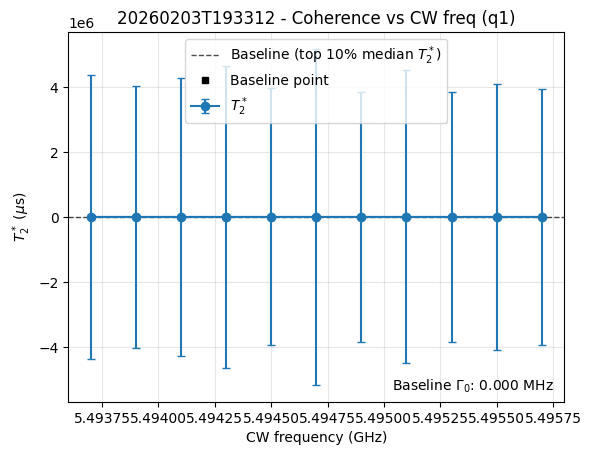

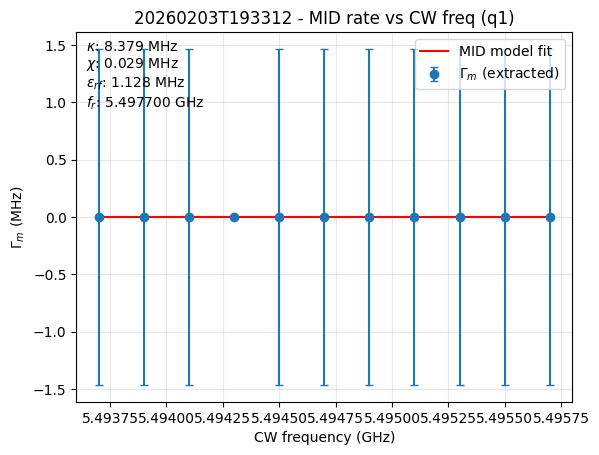

In [7]:
from experiments import new_coherence_spectroscopy


####################################################################################
q=qubits[1]
b=buses[0]
temporary_parameters = {}
q_temp_pars =deepcopy(q.parameters)
q_temp_pars.readout_amplitude = 0.4
q_temp_pars.readout_integration_length =1.2e-6
b_temp_pars =deepcopy(b.parameters)
#b_temp_pars.readout_integration_length =1e-6
# b_temp_pars.drive_lo_frequency = 6.0e9
temporary_parameters[q.uid] = q_temp_pars
temporary_parameters[b.uid] = b_temp_pars

print(q.readout_parameters())

#####################################################################################
options = new_coherence_spectroscopy.experiment_workflow.options()
#workflow.show_fields(options)
options.count(256)
options.update(False)
options.do_analysis(True)
options.ring_up(200e-6)
options.ring_down(100e-9)

######################################################################################
# Build and run resonator_spectroscopy_amplitude wormflow
co_spec = new_coherence_spectroscopy.experiment_workflow(
    session=session,
    qpu=qpu,
    qubit=q,
    bus= b,
    delays=np.linspace(0,10e-6,51), #delays=np.linspace(0,5e-6,21), 포인트 확보 중요
    CW_frequencies= b.parameters.resonance_frequency_bus+np.linspace(-1.0e6,1.0e6,11),
    #CW_frequencies= 5.5555e9 +np.linspace(-0.6e6,0.6e6,101),
    CW_amplitude=0.0018,
    CW_phase=0.0,
    detunings=0.4e6,
    temporary_parameters=temporary_parameters,
    options=options
)
co_spec_result = co_spec.run()
#co_spec_analysis_result = co_spec_result.tasks["analysis_workflow"]

In [8]:
co_spec_analysis_result = co_spec_result.tasks["analysis_workflow"]
fit = co_spec_analysis_result.tasks['fit_mid_rate_data'].output['q1']
fit.best_values

{'kappa': 8378545.046718673,
 'chi': 28769.753271913334,
 'epsilon_rf': 1128354.9636468026,
 'bare_freq': 5497699999.9999075}

In [9]:
from laboneq.simple import show_pulse_sheet
from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation

show_pulse_sheet(compiled_experiment=co_spec_result.tasks["compile_experiment"].output,name='test', interactive=True, max_events_to_publish=10000)
#plot_simulation(compiled_experiment=co_spec_result.tasks["compile_experiment"].output, length=300e-6)

[2026.02.03 19:33:15.863] INFO    Recompiling the experiment due to missing extra information in the compiled experiment. Compile with `OUTPUT_EXTRAS=True` and `MAX_EVENTS_TO_PUBLISH=10000` to bypass this step with a small impact on the compilation time.
[2026.02.03 19:33:15.867] INFO    Resolved modulation type of oscillator 'b0_drive_osc' on signal 'b0/drive' to HARDWARE
[2026.02.03 19:33:15.868] INFO    Resolved modulation type of oscillator 'q1_readout_acquire_osc' on signal 'q1/acquire' to SOFTWARE
[2026.02.03 19:33:15.868] INFO    Resolved modulation type of oscillator 'q1_drive_ge_osc' on signal 'q1/drive' to HARDWARE
[2026.02.03 19:33:15.869] INFO    Resolved modulation type of oscillator 'q1_drive_ef_osc' on signal 'q1/drive_ef' to HARDWARE
[2026.02.03 19:33:15.870] INFO    Starting LabOne Q Compiler run...
[2026.02.03 19:33:16.192] INFO    Schedule completed. [0.319 s]
[2026.02.03 19:33:16.802] INFO    Code generation completed for all AWGs. [0.609 s]
[2026.02.03 19:33:16.802

# Checking power dependece 

In [ ]:
from experiments import coherence_spectroscopy


####################################################################################
q=qubits[1]
b=buses[0]
temporary_parameters = {}
q_temp_pars =deepcopy(q.parameters)
q_temp_pars.readout_amplitude = 0.4
q_temp_pars.readout_integration_length =1.2e-6
b_temp_pars =deepcopy(b.parameters)
#b_temp_pars.readout_integration_length =1e-6
b_temp_pars.rip_length = 10e-6
# b_temp_pars.drive_lo_frequency = 6.0e9
temporary_parameters[q.uid] = q_temp_pars
temporary_parameters[b.uid] = b_temp_pars

print(q.readout_parameters())

#####################################################################################
options = coherence_spectroscopy.experiment_workflow.options()
#workflow.show_fields(options)
options.count(256)
options.update(False)
options.do_analysis(True)
options.ring_up(10e-6)
options.ring_down(100e-9)

######################################################################################
# Build and run resonator_spectroscopy_amplitude wormflow

#EXample
CW_amps = [0.0014,0.0016,0.0018]

chis=[]
kappas=[]
epsilons=[]
frs=[]

for CW_amp in CW_amps: 
    co_spec = coherence_spectroscopy.experiment_workflow(
        session=session,
        qpu=qpu,
        qubit=q,
        bus= b,
        delays=np.linspace(0,20e-6,51), #delays=np.linspace(0,5e-6,21), 포인트 확보 중요
        CW_frequencies= b.parameters.resonance_frequency_bus+np.linspace(-1.0e6,1.0e6,201),
        #CW_frequencies= 5.5555e9 +np.linspace(-0.6e6,0.6e6,101),
        CW_amplitude=0.0018,
        CW_phase=0.0,
        detunings=0.4e6,
        temporary_parameters=temporary_parameters,
        options=options
    )
    co_spec_result = co_spec.run()
    co_spec_analysis_result = co_spec_result.tasks["analysis_workflow"]
    co_spec_analysis_result = co_spec_result.tasks["analysis_workflow"]
    fit = co_spec_analysis_result.tasks['fit_mid_rate_data'].output['q1']
    kappas.append(fit.best_values['kappa'])
    chis.append(fit.best_values['chi'])
    epsilons.append(fit.best_values['epsilon_rf'])
    frs.append(fit.best_values['bare_freq'])

In [6]:
import numpy as np
import matplotlib.pyplot as plt

CW_amps = np.array([0.0014, 0.0016, 0.0018])

results = {k: {"val": [], "err": []} for k in ["kappa","chi","epsilon_rf","bare_freq"]}

for CW_amp in CW_amps:
    co_spec = coherence_spectroscopy.experiment_workflow(
        session=session,
        qpu=qpu,
        qubit=q,
        bus=b,
        delays=np.linspace(0, 20e-6, 51),
        CW_frequencies=b.parameters.resonance_frequency_bus + np.linspace(-1.0e6, 1.0e6, 201),
        CW_amplitude=CW_amp,   # <-- 
        CW_phase=0.0,
        detunings=0.4e6,
        temporary_parameters=temporary_parameters,
        options=options
    )
    co_spec_result = co_spec.run()
    fit = co_spec_result.tasks["analysis_workflow"].tasks["fit_mid_rate_data"].output["q1"]

    # fit 실패 대비
    if fit is None:
        for k in results:
            results[k]["val"].append(np.nan)
            results[k]["err"].append(np.nan)
        continue

    for k in results:
        p = fit.params[k]
        results[k]["val"].append(p.value)
        results[k]["err"].append(p.stderr if p.stderr is not None else np.nan)

# plot (4개 파라미터)
fig, axes = plt.subplots(2, 2, figsize=(8,6), sharex=True)
axes = axes.ravel()
for ax, k in zip(axes, ["kappa","chi","epsilon_rf","bare_freq"]):
    ax.errorbar(CW_amps, results[k]["val"], yerr=results[k]["err"], fmt="o-", capsize=3)
    ax.set_title(k)
    ax.set_xlabel("CW amplitude")
    ax.set_ylabel(k)
plt.tight_layout()


NameError: name 'coherence_spectroscopy' is not defined

In [ ]:
# custom coherent spec analysis (offline from saved JSON)
from __future__ import annotations

import json
from pathlib import Path

import numpy as np
from analysis import coherence_spectroscopy as coh_analysis

# Work whether the notebook cwd is repo root or this folder.
base = Path("examples/selectiveRIP")
if not base.exists():
    base = Path(".")

data_path = base / "fit-data.input.processed-data-dict.json"
if not data_path.exists():
    raise FileNotFoundError(f"Could not find {data_path} (cwd={Path.cwd()})")

with open(data_path, "r") as f:
    processed_raw = json.load(f)


def _pairs_to_complex(data_pairs: np.ndarray) -> np.ndarray:
    """Convert [..., real, imag, real, imag, ...] to complex array."""
    real = data_pairs[..., 0::2]
    imag = data_pairs[..., 1::2]
    return real + 1j * imag


processed_data_dict: dict[str, dict] = {}
for uid, entry in processed_raw.items():
    converted: dict = {}
    for key, value in entry.items():
        if key == "data_raw" and isinstance(value, dict) and "data" in value:
            data_pairs = np.asarray(value["data"], dtype=float)
            converted[key] = _pairs_to_complex(data_pairs)
        elif isinstance(value, list):
            converted[key] = np.asarray(value)
        else:
            converted[key] = value
    processed_data_dict[uid] = converted

# Use the qubit objects already defined earlier in the notebook.
q = qubits[0]

# IMPORTANT: set this to the detuning you used in the experiment.
detuning_used = 0.4e6

fit_results = coh_analysis.fit_data([q], processed_data_dict)
qubit_parameters = coh_analysis.extract_qubit_parameters([q], fit_results, detuning_used)
mid_fit_results = coh_analysis.fit_mid_rate_data([q], qubit_parameters)

print(qubit_parameters["per_frequency"][q.uid]["best_index"])
print(qubit_parameters["new_parameter_values"][q.uid])

# Plot both T2* and the MID rate fit.
fig_t2 = coh_analysis.plot_t2_star_vs_frequency([q], qubit_parameters)[q.uid]
fig_mid = coh_analysis.plot_MID_rate_vs_frequency([q], qubit_parameters, mid_fit_results)[q.uid]
fig_t2, fig_mid



# Amplitude calibration

In [ ]:
from experiments import amplitude_fine
q = qubits[0]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
temporary_parameters[q.uid] = temp_pars
#temp_pars.ge_drive_amplitude_pi =0.64
#######################################################################
repetitions =np.arange(1,12) # Due to short T1, 20   
#######################################################################
options = amplitude_fine.experiment_workflow_x180.options()
options.update(False)
options.use_cal_traces(True)
#options.do_pca(False)

#print(workflow.show_fields(options))

###################################################################
error_amp = amplitude_fine.experiment_workflow_x180(
    session=session,
    qpu=qpu,
    qubits=q,
    repetitions=repetitions,
    temporary_parameters=temporary_parameters,
    options=options
)

error_amp_result = error_amp.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
print(error_amp_result.tasks['analysis_workflow'].output)

In [ ]:
from experiments import amplitude_fine
q = qubits[0]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
temporary_parameters[q.uid] = temp_pars
#######################################################################
repetitions =np.arange(1,10)
#######################################################################
options = amplitude_fine.experiment_workflow_x90.options()
options.update(False)
options.use_cal_traces(True)
options.count(1024)

#print(workflow.show_fields(options))

###################################################################
error_amp_half = amplitude_fine.experiment_workflow_x90(
    session=session,
    qpu=qpu,
    qubits=q,
    repetitions=repetitions,
    temporary_parameters=temporary_parameters,
    options=options
)

error_amp_half_result = error_amp_half.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
print(error_amp_half_result.tasks['analysis_workflow'].output)

In [ ]:
# from helper import save_qubit_parameters
# save_qubit_parameters(qubits={ qubit.uid : qubit for qubit in qubits}, save_folder="./qubit_parameters/", filename="COSPEC2")